## Hausarbeit 7
• Modifizieren Sie das Modell so, dass es einen 5x5 Kernel verwendet <br>
    1. Wie verändert sich dann die Anzahl der freien Parameter im Modell? <br>
    2. Verbessert oder verschlechtert sich Overfitting? <br>
    
• Können Sie ein Bild finden, welches weder Vogel noch Flugzeug <br>
enthält, von dem Netz aber mit mindestens 95% wahrscheinlichkeit 
als eines der beiden Objekte erkannt wird?


<span style="color:red">**Anmerkung: Die Beantwortung der Fragen finden Sie im Verlauf des Notebooks**</span>

In [17]:
# Laden der notwendigen Bibliotheken
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import os
import collections
os.environ['KMP_DUPLICATE_LIB_OK']='True'
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import datetime 
import torch
import time
import random

torch.set_printoptions(edgeitems=2)
torch.manual_seed(123)

In [18]:
# Definition der einzelnen Klassen
class_names_bird_plane = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']

In [19]:
# Laden des Datensatzes: Umwandlung in einen Tensor und Normalisierung der Daten
data_path = '../data-unversioned/p1ch6/'

# Trainingsdatensatz
cifar10 = datasets.CIFAR10(
    data_path, train=True, download=True,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4915, 0.4823, 0.4468),
                             (0.2470, 0.2435, 0.2616))
    ]))

# Validierungsdatensatz
cifar10_val = datasets.CIFAR10(
    data_path, train=False, download=True,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4915, 0.4823, 0.4468),
                             (0.2470, 0.2435, 0.2616))
    ]))

Files already downloaded and verified
Files already downloaded and verified


In [20]:
# Bildung eines neuen Datensatzes, nur mit Bird und Flugzeug Bildern
label_map = {0: 0, 2: 1}
class_names_bird_plane = ['airplane', 'bird']

# Trainingsdatensatz
cifar2 = [(img, label_map[label])
          for img, label in cifar10
          if label in [0, 2]]

# Validierungsdatensatz
cifar2_val = [(img, label_map[label])
              for img, label in cifar10_val
              if label in [0, 2]]

### 1. Aufgabe: Vergleich 5x5 und 3x3 Kernel

#### a.) 3x3 Kernel:

In [21]:
# Definition des Baseline-Modells:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        
        # Definition eines Convolutional-Layers mit einem 3x3 Kernel
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(16, 8, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(8 * 8 * 8, 32)
        self.fc2 = nn.Linear(32, 2)
        
    def forward(self, x):
        out = F.max_pool2d(torch.tanh(self.conv1(x)), 2)
        out = F.max_pool2d(torch.tanh(self.conv2(out)), 2)
        out = out.view(-1, 8 * 8 * 8)
        out = torch.tanh(self.fc1(out))
        out = self.fc2(out)
        return out

In [22]:
# Definition des Trainingloops
def training_loop(n_epochs, optimizer, model, loss_fn, train_loader):
    for epoch in range(1, n_epochs + 1):  
        loss_train = 0.0
        for imgs, labels in train_loader:  
            
            outputs = model(imgs)  
            
            loss = loss_fn(outputs, labels)  

            optimizer.zero_grad()  
            
            loss.backward()  
            
            optimizer.step()  

            loss_train += loss.item()  

        if epoch == 1 or epoch % 10 == 0:
            print('{} Epoch {}, Training loss {}'.format(
                datetime.datetime.now(), epoch,
                loss_train / len(train_loader))) 

In [23]:
# Trainieren des Modells
train_loader = torch.utils.data.DataLoader(cifar2, batch_size=64,
                                           shuffle=True) 

model3x3 = Net()  
optimizer = optim.SGD(model3x3.parameters(), lr=1e-2)  
loss_fn = nn.CrossEntropyLoss()  

training_loop(  
    n_epochs = 100,
    optimizer = optimizer,
    model = model3x3,
    loss_fn = loss_fn,
    train_loader = train_loader,
)

print('Die Anzahl der freien Parameter beträgt:', sum(p.numel() for p in model3x3.parameters()))

2023-06-02 14:48:19.422257 Epoch 1, Training loss 0.5803694548500571
2023-06-02 14:48:38.914722 Epoch 10, Training loss 0.33222396576860147
2023-06-02 14:49:00.907746 Epoch 20, Training loss 0.2911597882296629
2023-06-02 14:49:50.982133 Epoch 30, Training loss 0.2659074995358279
2023-06-02 14:50:14.538725 Epoch 40, Training loss 0.24671235917859777
2023-06-02 14:50:36.141955 Epoch 50, Training loss 0.22851365050122996
2023-06-02 14:50:57.585533 Epoch 60, Training loss 0.2139048953629603
2023-06-02 14:51:18.704722 Epoch 70, Training loss 0.19706508678615473
2023-06-02 14:51:45.603013 Epoch 80, Training loss 0.18136654946075123
2023-06-02 14:52:09.125252 Epoch 90, Training loss 0.16724600268017714
2023-06-02 14:52:32.133050 Epoch 100, Training loss 0.1532175787457615
Die Anzahl der freien Parameter beträgt: 18090


In [24]:
# Berechnung der Genauigkeit des Modells für die Trainings und Validierungsdaten:
train_loader = torch.utils.data.DataLoader(cifar2, batch_size=64,
                                           shuffle=False)
val_loader = torch.utils.data.DataLoader(cifar2_val, batch_size=64,
                                         shuffle=False)
all_acc_dict = collections.OrderedDict()

def validate(model, train_loader, val_loader):
    for name, loader in [("train", train_loader), ("val", val_loader)]:
        correct = 0
        total = 0

        with torch.no_grad():  
            for imgs, labels in loader:
                outputs = model(imgs)
                _, predicted = torch.max(outputs, dim=1)
                total += labels.shape[0] 
                correct += int((predicted == labels).sum())  

        print("Accuracy {}: {:.2f}".format(name , correct / total))

validate(model3x3, train_loader, val_loader)


Accuracy train: 0.92
Accuracy val: 0.88


#### b.) 5x5 Kernel

In [26]:
# Definition des Baseline-Modells:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        
        # Definition eines Convolutional-Layers mit einem 3x3 Kernel
        self.conv1 = nn.Conv2d(3, 16, kernel_size=5, padding=2)
        self.conv2 = nn.Conv2d(16, 8, kernel_size=5, padding=2)
        self.fc1 = nn.Linear(8 * 8 * 8, 32)
        self.fc2 = nn.Linear(32, 2)
        
    def forward(self, x):
        out = F.max_pool2d(torch.tanh(self.conv1(x)), 2)
        out = F.max_pool2d(torch.tanh(self.conv2(out)), 2)
        out = out.view(-1, 8 * 8 * 8)
        out = torch.tanh(self.fc1(out))
        out = self.fc2(out)
        return out

# Trainieren des Modells
train_loader = torch.utils.data.DataLoader(cifar2, batch_size=64,
                                           shuffle=True) 

model5x5 = Net()  
optimizer = optim.SGD(model5x5.parameters(), lr=1e-2)  
loss_fn = nn.CrossEntropyLoss()  

training_loop(  
    n_epochs = 100,
    optimizer = optimizer,
    model = model5x5,
    loss_fn = loss_fn,
    train_loader = train_loader,
)

print('Die Anzahl der freien Parameter mit dem 5x5 Kernel beträgt:', sum(p.numel() for p in model5x5.parameters()))

2023-06-02 14:54:43.942449 Epoch 1, Training loss 0.5661669191281506
2023-06-02 14:55:07.822064 Epoch 10, Training loss 0.32106253960330017
2023-06-02 14:55:34.801543 Epoch 20, Training loss 0.2821221894519344
2023-06-02 14:56:03.682806 Epoch 30, Training loss 0.24960062994508986
2023-06-02 14:56:35.604715 Epoch 40, Training loss 0.2233744926608292
2023-06-02 14:57:07.467716 Epoch 50, Training loss 0.2014970294893927
2023-06-02 14:57:39.367414 Epoch 60, Training loss 0.17906245788571182
2023-06-02 14:58:07.289256 Epoch 70, Training loss 0.15664368816859023
2023-06-02 14:58:34.290994 Epoch 80, Training loss 0.13874214818807923
2023-06-02 14:59:01.159905 Epoch 90, Training loss 0.118633986943087
2023-06-02 14:59:27.752840 Epoch 100, Training loss 0.10244492930211839
Die Anzahl der freien Parameter mit dem 5x5 Kernel beträgt: 20906


In [27]:
# Berechnung der Genauigkeit des Modells für die Trainings und Validierungsdaten:
train_loader = torch.utils.data.DataLoader(cifar2, batch_size=64,
                                           shuffle=False)
val_loader = torch.utils.data.DataLoader(cifar2_val, batch_size=64,
                                         shuffle=False)
all_acc_dict = collections.OrderedDict()

def validate(model5x5, train_loader, val_loader):
    for name, loader in [("train", train_loader), ("val", val_loader)]:
        correct = 0
        total = 0

        with torch.no_grad():  
            for imgs, labels in loader:
                outputs = model5x5(imgs)
                _, predicted = torch.max(outputs, dim=1) 
                total += labels.shape[0]  
                correct += int((predicted == labels).sum()) 

        print("Accuracy {}: {:.2f}".format(name , correct / total))

validate(model5x5, train_loader, val_loader)

Accuracy train: 0.96
Accuracy val: 0.88


#### 1. Wie verändert sich dann die Anzahl der freien Parameter im Modell? <br>
Freie Parameter (3x3 Kernel) = 18.090
Freie Parameter (5x5 Kernel) = 20.906
Die Anzahl der freien Parameter steigt mit der Größe des Kernels an. 

#### 2. Verbessert oder verschlechtert sich Overfitting? <br>
Durch den 5x5-Kernel verschlechtert sich das Overfitting. Dies ist daran erkenntlich, dass die Diskrepanz zwischen der Genauigkeit des Modells auf den Trainingsdaten und den Validierungsdaten von 0,04 auf 0,08 ansteigt. Zusätzlich nähert sich die Genauigkeit des Modells auf den Trainingsdaten fast 100 % an, was darauf hinweist, dass das Modell nahezu perfekt auf die Trainingsdaten trainiert ist.

#### 2.Aufgabe: Suche nach einem Bild, welches weder Vogel noch Flugzeug ist, aber zu 95% Wahrscheinlichkeit als eines der beiden Objekte erkennt wird:

Files already downloaded and verified


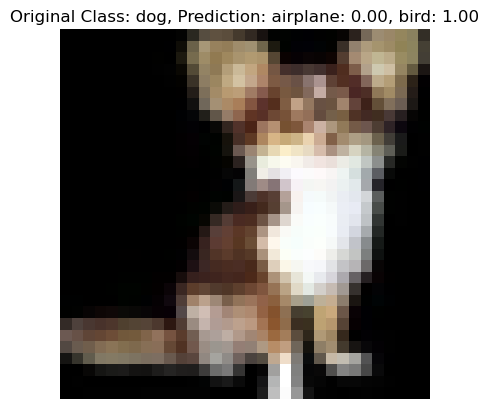

In [45]:
# Laden des trainierten Modells zur Vorhersage
model = model3x3
model.eval()

# Laden des CIFAR-10-Validierungsdatensatzes ohne Normalisierung
cifar10_val = datasets.CIFAR10(data_path, train=False, download=True, transform=
                                transforms.Compose([transforms.ToTensor(),]))


# Reduzierung des Datensatzes auf die Klassen, mit denen das Modell nicht trainiert wurde. 
label_map_without_bird_plane = {1: 0, 3: 1, 4: 2, 5: 3, 6: 4, 7: 5, 8: 6, 9: 7}
class_names_wihtout_bird_plane = ['automobile', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
cifar10_without_bird_plane_val = [(img, label_map_without_bird_plane[label]) for img, label in cifar10_val if label in [1, 3, 4, 5, 6, 7, 8, 9]]

# Zufällige Auswahl eines Bildes aus dem reduzierten CIFAR10-Datensatz
index = random.randint(0, len(cifar10_without_bird_plane_val)-1)
image, label = cifar10_without_bird_plane_val[index]

# Durchführung der Vorhersage mit dem selektierten Bild und dem trainierten Modell. 
output = model(image.unsqueeze(0))
def softmax(x):
    return torch.exp(x) / torch.exp(x).sum()

probabilities = softmax(output)[0]

# Überprüfen der Wahrscheinlichkeiten für die Klassen "Flugzeug" und "Vogel"
Prob_airplane = probabilities[0]
Prob_bird = probabilities[1]

# Bestimmung der eigentlichen Klasse des Bildes. 
Original_class = class_names_wihtout_bird_plane[label]

# Plotten des Bildes
plt.imshow(transforms.ToPILImage()(image))
plt.axis('off')
plt.title(f'Original Class: {class_names_wihtout_bird_plane[label]}, Prediction: airplane: {Prob_airplane:.2f}, bird: {Prob_bird:.2f}')
plt.show()